### Bootstrap

Не всегда тот показатель, который нас интересует во время анализа, можно проверить готовым тестом. Для подобных непонятных ситуаций аналитиками часто используется метод бутстрапа (bootstrap), позволяющий оценить доверительный интервал для любого интересующего нас показателя.   

In [1]:
from scipy.stats import bootstrap
import pandas as pd
import numpy as np
import seaborn as sns 

In [3]:
df = pd.read_csv('bootstrap_data.csv')
df.head()

,value,group
0,100.719713,experimental
1,106.771525,experimental
2,106.974612,experimental
3,109.249662,experimental
4,116.230142,experimental


In [6]:
df.groupby('group', as_index=False).agg({'value':'count'})

,group,value
0,control,760
1,experimental,494


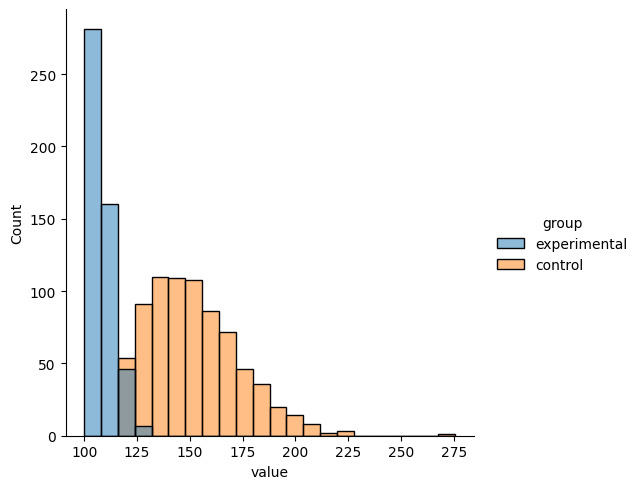

In [4]:
sns.displot(data=df, x='value', hue='group')

Дисперсия между двумя группами различается, посмотрим на их средние и медианы.

In [11]:
df.groupby('group').agg({'value':'median'})

,value
group,
control,148.832127
experimental,106.982597


In [12]:
df.groupby('group').agg({'value':'mean'})

,value
group,
control,151.995280
experimental,107.953235


При агрегации, в данных, мы получили различия между тестовой группой и контрольной. 
Следующим шагом нам необходимо статисчитески подтвердить различия в группах.

Для проверки различий мы будем использовать bootstrap.

Рассмотрим наши группы более подробно:

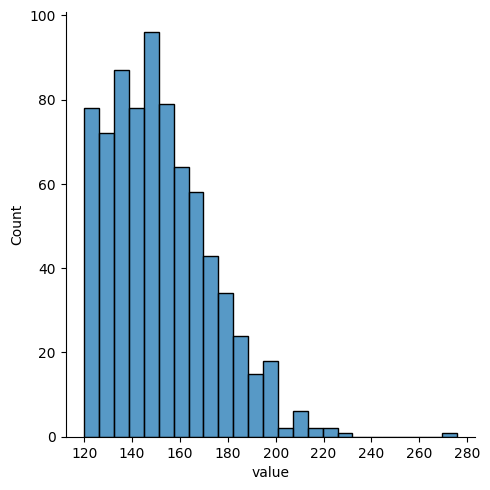

In [39]:
control_df = df[df.group=='control']
experimental_df = df[df.group=='experimental']
sns.displot(data=control_df, x='value')

In [19]:
control_df.value.median()

148.83212650911054

Создаем выборку на основе нашей выборки такого же размера, только данные мы из основной выборки мы можем брать повторно, это будет выглядеть примерно вот так:

In [20]:
control_df.sample(frac=1, replace=True)

,value,group
881,163.374802,control
1081,155.734957,control
1086,120.936817,control
776,158.763300,control
708,130.246339,control
...,...,...
602,122.179473,control
1005,148.672185,control
823,147.264728,control
663,126.902747,control


Построим график нашей новой выборки, каждый раз когда мы будем это повторять, он будет немного другой:

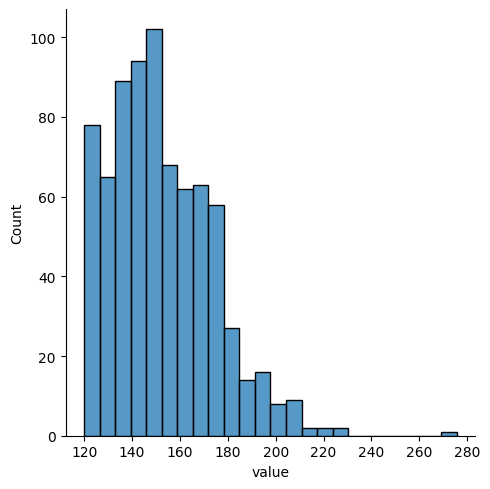

In [24]:
sns.displot(data=control_df.sample(frac=1, replace=True), x='value')

Таких повторений будет брать 10000 раз:

In [26]:
n = 10000
medians=[]

In [27]:
for i in range(n):
    sample_data = control_df.sample(frac=1, replace=True)
    sample_meadian = sample_data.value.median()
    medians.append(sample_meadian)

In [32]:
np.mean(medians) #средняя всех медиан повторных выборок практически равна основной выборке

148.87062911964478

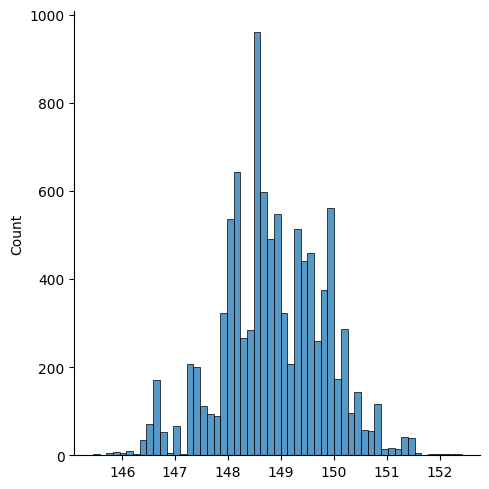

In [33]:
sns.displot(medians)

Почему же мы проводим такие действия?
- В методе bootstrap лежит логика ЦПТ;
- Мы как бы вытягиваем сами себя по данным которые есть;
- При множественной выборке, мы можем построить доверительный интервал изменчивости рассматриваемого признака;

Теперь мы можем отобрать 95% интервал изменчивости для нашей медианы:

In [35]:
pd.Series(medians).quantile(0.975)

150.7763799798184

In [36]:
pd.Series(medians).quantile(0.025)

146.68203474174567

95% всех наших выборочных медиан оказались между 146.68 : 150.77

Основная идея bootstrap заключается в нахождении доверительного интервала для рассматриваемого признака в двух группах: тестового и контрольного. Если доверительные интервалы не пересекаются, то можно говорить о стат значимых различиях!

Для решения задач с помощью bootstrap можно воспользоваться уже готовыми библиотеками:

In [38]:
bootstrap((control_df.value, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=146.66616569213227, high=150.79195404716057), bootstrap_distribution=array([150.74580151, 149.94862834, 149.73022006, ..., 149.36010403,
       148.98329775, 148.54316567]), standard_error=0.9981175814516542)

In [40]:
bootstrap((experimental_df.value, ), np.median)

BootstrapResult(confidence_interval=ConfidenceInterval(low=106.2595922808035, high=107.77649076966284), bootstrap_distribution=array([107.94100147, 106.89104051, 107.03828831, ..., 107.47886897,
       106.4066084 , 106.45058367]), standard_error=0.4068703491592904)

В приведенном выше примере: 
- доверительные интервалы не пересекаются;
- можно говорить о стат значимых различиях между двумя группами;

Также можно использовать немного видоизмененный bootstrap, когда мы в цикле считаем медианы тестовой и контрольной группы, далее получаем их разность, находим 95% доверительные интервалы, и если, в этот интервал не попадает 0, то можно говорить о стат значимых различиях между группами.